---
title: "3D Inversion of TMI Data to Recover a Susceptibility Model"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Keywords:** total magnetic intensity, integral formulation, inversion, sparse norm, tensor mesh, tree mesh.

</br>

**Summary:** Here we invert total magnetic intensity data to recover a susceptibility model. We demonstrate two approaches for recovering a susceptibility model:

1. Weighted least-squares inversion for a tensor mesh
2. Iteratively re-weighted least-squares (IRLS) inversion for a tree mesh

The *weighted least-squares* approach is a great introduction to geophysical inversion with SimPEG. One drawback however, is that it recovers smooth structures which may not be representative of the true model. To recover sparse and/or blocky structures, we demonstrate the *iteratively re-weighted least-squares* approach. Because this tutorial focusses primarily on 
inversion-related functionality, we urge the reader to become familiar with functionality explained in the [3D Forward Simulation of Total Magnetic Intensity Data](fwd_magnetics_anomaly_3d.ipynb) tutorial before working through this one.

</br>

**Learning Objectives:**

- Introduce geophysical inversion with SimPEG.
- Assigning appropriate uncertainties to total magnetic intensity data.
- Designing a suitable mesh for magnetic inversion.
- Choosing suitable parameters for the inversion.
- Specifying directives that are applied throughout the inversion.
- Apply the sensitivity weighting commonly used when inverting magnetic data.
- Inversion with weighted least-squares and sparse-norm regularizations.
- Analyzing inversion outputs.

Although we consider total magnetic intensity data in this tutorial, the same approach can be used to invert magnetic gradiometry data.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to the forward simulation of magnetic data are imported from the [simpeg.potential_fields.magnetics](xref:simpeg#simpeg.potential_fields.magnetics) module. Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.potential_fields import magnetics
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

## Load Tutorial Files

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data and topography. For this tutorial, the observed data and topography files are provided. Here, we download and import the observed data and topography into the SimPEG framework.

In [2]:
# URL to download from repository assets
data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/04-magnetics/inv_magnetics_induced_3d_files.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "magnetics_topo.txt"
data_filename = dir_path + "magnetics_data.obs"

overwriting F:\Marco\Profissional\IGc-USP\Extensao\2026\XXVIII_Escola_de_Verao_Geofisica_IAG_USP\praticas\SimPEG_Exercise\inv_magnetics_induced_3d\inv_magnetics_induced_3d_files.tar.gz
   saved to: F:\Marco\Profissional\IGc-USP\Extensao\2026\XXVIII_Escola_de_Verao_Geofisica_IAG_USP\praticas\SimPEG_Exercise\inv_magnetics_induced_3d\inv_magnetics_induced_3d_files.tar.gz
Download completed!


For this tutorial, the data are organized within basic XYZ files. However, SimPEG does allow the user to import UBC-GIF formatted magnetic data files; see [read_mag3d_ubc](xref:simpeg#simpeg.utils.io_utils.read_mag3d_ubc).

In [3]:
# Load topography (xyz file)
topo_xyz = np.loadtxt(str(topo_filename))

# Load field data (xyz file)
dobs = np.loadtxt(str(data_filename))

## Plot Observed Data and Topography

Here we plot the synthetic total magnetic intensity data and local topography.

In [4]:
# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

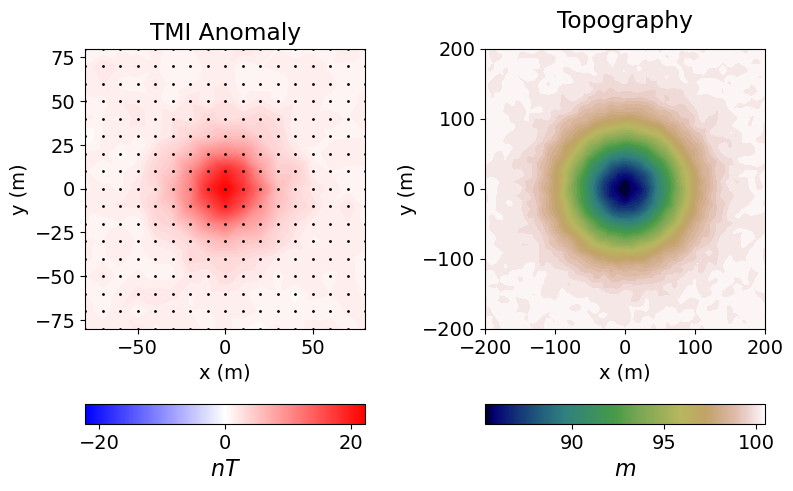

In [5]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

v_max = np.max(np.abs(dobs))
norm1 = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)

plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": mpl.cm.bwr, "norm": norm1},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

cx1 = fig.add_axes([0.05, 0.18, 0.35, 0.04])
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$nT$", size=16)

ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    topo_xyz[:, 0:2],
    topo_xyz[:, -1],
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)
ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

cx2 = fig.add_axes([0.55, 0.18, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(topo_xyz[:, -1]), vmax=np.max(topo_xyz[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("$m$", size=16)

plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**For total magnetic intensity data,** a constant floor value is generally applied to all data. We generally avoid assigning percent uncertainties because the inversion prioritizes fitting the background over fitting anomalies. The floor value for the uncertainties may be chosen based on some knowledge of the instrument error, or it may be chosen as some fraction of the largest anomaly value. For this tutorial, the floor uncertainty assigned to all data is 2% of the maximum observed total magnetic intensity value. **For magnetic gradiometry data,** you may choose to assign a different floor value to each data component. 

In [6]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.02 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.44378


## Define the Survey

Here, we define the survey geometry. The survey consists of a 160 m x 160 m grid of equally spaced receivers located 10 m
above the surface topography. For a more comprehensive description of constructing magnetic surveys in SimPEG, see the [3D Forward Simulation of Total Magnetic Intensity Data](fwd_magnetics_anomaly_3d.ipynb) tutorial.

In [7]:
# Define the component(s) of the field we are inverting as a list. Here we will
# invert total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]

# Define the inducing field
inclination = 90  # inclination [deg]
declination = 0  # declination [deg]
amplitude = 50000  # amplitude [nT]

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=amplitude,
    inclination=inclination,
    declination=declination,
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

## Define the Data

The SimPEG [Data](xref:simpeg#simpeg.data.Data) class is required for inversion and connects the observed data, uncertainties and survey geometry.

In [8]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

## Weighted Least-Squares Inversion on a Tensor Mesh

### Design a (Tensor) Mesh

Meshes are designed using the [discretize package](https://discretize.simpeg.xyz). Here, we design a [tensor mesh](xref:discretize#discretize.TensorMesh). See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes. When designing a mesh for magnetic inversion, we must consider the spatial wavelengths of the signals contained within the data. If the data spacing is large and/or the signals present in the data are smooth, larger cells can be used to construct the mesh. If the data spacing is smaller and compact anomalies are observed, smaller cells are needed to characterize the structures responsible. And smaller cells are required when the effects of surface topography are significant.

**General rule of thumb:** The minimum cell size in each direction is at most 0.5 - 1 times the station spacing. And the thickness of the padding is at least 1 - 2 times the width of the survey region.

In [9]:
# Generate tensor mesh with top at z = 0 m
dh = 5.0  # minimum cell size
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along x
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along y
hz = [(dh, 5, -1.3), (dh, 15)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

### Define the Active Cells

Whereas cells below the Earth's surface contribute towards simulated magnetic anomalies, air cells do not.
The set of mesh cells used in the forward simulation are referred to as 'active cells'. Unused cells (air cells) are 'inactive cells'. Here, the discretize [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [10]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz)
n_tensor_active = int(active_tensor_cells.sum())

### Mapping from the Model to Active Cells

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For whatever model we choose, we must define a mapping from the set of model parameters (a [1D numpy.ndarray](xref:numpy#numpy.ndarray)) to the active cells in the mesh. Mappings are created using the [simpeg.maps](xref:simpeg#simpeg.maps.IdentityMap) module. For the tutorial exercise, the model is the susceptibility values for all active cells. As such, our mapping is an identity mapping, whose dimensions are equal to the number of active cells.

In [11]:
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

### Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion and does not necessarily represent an initial estimate of the true model. Because the integral formulation used to solve the magnetic forward simulation is linear, the optimization problem we must solve is a linear least-squares problem, making the choice in starting model insignificant. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration. For magnetic inversion, the starting model is frequently a constant vector with a very small value.

The **reference model** is used to include a-priori information. The impact of the reference model on the inversion will be discussed in another tutorial. Assuming the contribution from all regional structures has been removed from the magnetic data, and assuming we have not a-priori information, the reference model for basic inversion of magnetic data is zero or equal to the starting model.

Notice that the length of the starting and reference models is equal to the number of active mesh cells!!!

In [12]:
starting_tensor_model = 1e-6 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [13]:
# Mapping to ignore inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

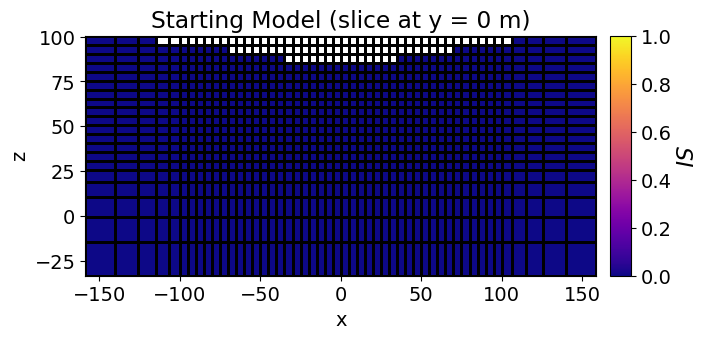

In [14]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)

plt.show()

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for total magnetic intensity data was discussed in the [3D Forward Simulation of Total Magnetic Intensity Data](fwd_magnetics_anomaly_3d.ipynb) tutorial. Here, we use the [3D integral formulation](xref:simpeg#simpeg.potential_fields.magnetics.simulation.Simulation3DIntegral).

In [16]:
simulation_L2 = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    model_type="scalar",
    chiMap=tensor_model_map,
    active_cells=active_tensor_cells,
    engine="choclo",
)

:::{tip}
By choosing `engine="choclo"` we can make our simulation to run the faster and more memory efficient implementation of the gravity forward that uses [Numba](https://numba.pydata.org/) and [Choclo](https://www.fatiando.org/choclo) under the hood. To do so, we need to have [Choclo installed](https://www.fatiando.org/choclo/latest/install.html).
:::

### Define the Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](xref:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [17]:
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)

### Define the Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). Here, we use the [WeightedLeastSquares](xref:simpeg#simpeg.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Here, length scales along x, y and z are used to balance the smallness and smoothness terms. And the reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros.

In [18]:
reg_L2 = regularization.WeightedLeastSquares(
    tensor_mesh,
    active_cells=active_tensor_cells,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=1.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=False,
)

### Define the Optimization Algorithm

Here, we use the [ProjectedGNCG](xref:simpeg#simpeg.optimization.ProjectedGNCG) class to solve the optimization problem using projected Gauss-Newton with conjugate gradietn solver. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches. Here, the `lower` property is set to 0 to ensure recovered susceptibility values are positive.

In [19]:
opt_L2 = optimization.ProjectedGNCG(
    maxIter=100, lower=0.0, maxIterLS=20, maxIterCG=10, tolCG=1e-2
)

C:\Users\Marco Couto\miniconda3\envs\veraoiag2026\Lib\site-packages\simpeg\optimization.py:1535: FutureWarning: InexactCG.tolCG has been deprecated, please use InexactCG.cg_atol. It will be removed in version 0.26.0 of SimPEG.
  self.tolCG = val
C:\Users\Marco Couto\miniconda3\envs\veraoiag2026\Lib\site-packages\simpeg\optimization.py:1061: FutureWarning: InexactCG.maxIterCG has been deprecated, please use InexactCG.cg_maxiter. It will be removed in version 0.26.0 of SimPEG.
  self.maxIterCG = val


### Define the Inverse Problem

We use the [BaseInvProblem](xref:simpeg#simpeg.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [20]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Provide Inversion Directives

Directives represent operations that are carried out during the inversion. Here, we apply common directives for weighted least-squares inversion of magnetic data and describe their roles. These are:

- [UpdateSensitivityWeights](xref:simpeg#simpeg.directives.UpdateSensitivityWeights): Apply sensitivity weighting to counteract the natural tendancy of potential field inversion to cluster recovered structures near the receivers. Because the 3D integral formulation is linear, the sensitivity weighting is independent of the model and does not need to be updated throughout the inversion, so we set `every_iteration=False`.

- [UpdatePreconditioner](xref:simpeg#simpeg.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem.

- [BetaEstimate_ByEig](xref:simpeg#simpeg.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](xref:simpeg#simpeg.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta.

- [TargetMisfit](xref:simpeg#simpeg.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [21]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

### Define and Run the Inversion

We define the inversion using the [BaseInversion](xref:simpeg#simpeg.inversion.BaseInversion) class. The inversion class must be instantiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [22]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.25.0


INFO: Directive TargetMisfit: Target data misfit is 289.0


================================================= Projected GNCG =================================================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS   iter_CG   CG |Ax-b|/|b|  CG |Ax-b|   Comment   
-----------------------------------------------------------------------------------------------------------------
   0  4.01e+05  2.68e+04  3.01e-07  2.68e+04                         0           inf          inf                
   1  4.01e+05  3.24e+03  7.78e-03  6.35e+03    1.75e+06      0      10       2.08e-01     3.73e+05              
   2  2.00e+05  7.94e+02  1.19e-02  3.19e+03    4.93e+05      0      10       1.04e-03     5.12e+02              
   3  1.00e+05  4.09e+02  1.45e-02  1.86e+03    1.21e+05      0      10       4.86e-03     5.87e+02              
   4  5.01e+04  2.47e+02  1.67e-02  1.08e+03    7.06e+04      0      10       1.03e-02     7.30e+02              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 5.3610e+01 <=

### Plot the Data Misfit

This step is necessary for determining whether the recovered model accurately reproduces observed anomalies. Here, we plot the observed data, predicted data for the recovered model, and the misfit. As we can see, the predicted data fits the background somewhat better than the anomalies. As a result, you may reassign smaller uncertainties in these areas and re-run the inversion in order to better fit the anomalies. We will do this for the iteratively reweighted least-squares inversion.

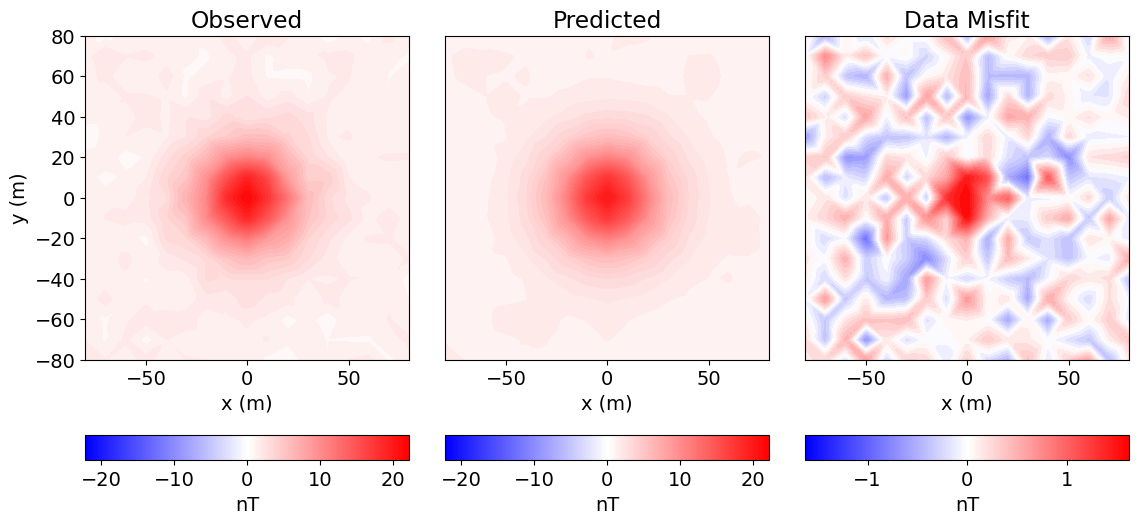

In [23]:
# Predicted data with final recovered model.
dpred = inv_prob_L2.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred, (dobs - dpred)]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["nT", "nT", "nT"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

### Plot the Recovered Model

As we can see, weighted least-squares regularization leads to the recovery of smooth models. And even with sensitivity weighting, there is a tendancy for gravity anomaly inversion to place recovered structures near the Earth's surface.

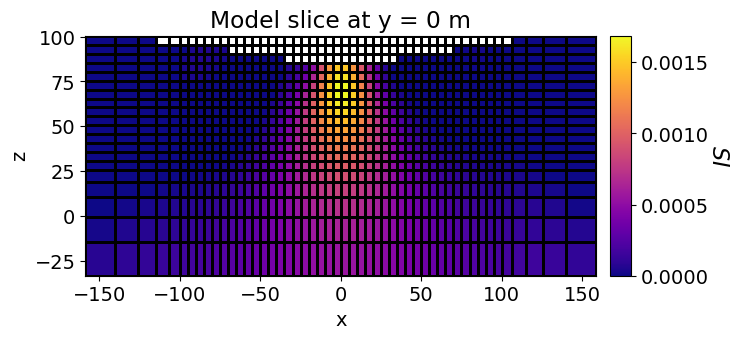

In [24]:
# Plot Recovered Model
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)

plt.show()

## Iteratively Re-weighted Least-Squares Inversion

Here, we provide a step-by-step best-practices approach for iteratively IRLS inversion of total magnetic intensity data on a tree mesh. Many of the steps are the same as our previous approach. As a result, we will avoid repeating information whenever possible.

### Reassign the Uncertainties

Prior to performing the IRLS inversion, we decrease the uncertainties at the locations we observed the largest data misfits. Here, our goal is to recover a model that better fits the anomalies. 

In [25]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / uncertainties

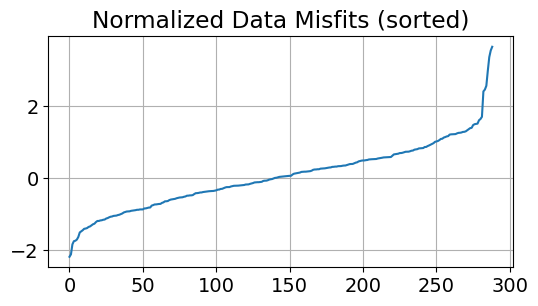

In [26]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.show(fig)

In [27]:
# Generate new uncertainties
new_uncertainties = uncertainties.copy()
new_uncertainties[np.abs(normalized_data_misfits) > 2.0] /= 2.5

In [28]:
# Generate new data object
new_data_object = data.Data(survey, dobs=dobs, standard_deviation=new_uncertainties)

### Design a (Tree) Mesh

Here, we design a [tree mesh](xref:discretize#discretize.TreeMesh). See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating tree meshes. The same approach used to construct the tensor mesh used in the weighted least-squares inversion example applies to tree meshes.

In [29]:
dx = 5  # minimum cell width (base tree_mesh cell width) in x
dy = 5  # minimum cell width (base tree_mesh cell width) in y
dz = 5  # minimum cell width (base tree_mesh cell width) in z

x_length = 240.0  # domain width in x
y_length = 240.0  # domain width in y
z_length = 120.0  # domain width in z

# Compute number of base tree_mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base tree_mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
tree_mesh = TreeMesh([hx, hy, hz], x0="CCN", diagonal_balance=True)

# Shift vertically to top same as maximum topography
tree_mesh.origin += np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

# Refine based on surface topography
tree_mesh.refine_surface(topo_xyz, padding_cells_by_level=[2, 2], finalize=False)

# Refine box based on region of interest
wsb_corner = np.c_[-100, -100, 20]
ent_corner = np.c_[100, 100, 100]
# Note -1 is a flag for smallest cell size
tree_mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

tree_mesh.finalize()

### Define the Active Cells

In [30]:
ind_tree_active = active_from_xyz(tree_mesh, topo_xyz)
n_tree_active = int(ind_tree_active.sum())

### Mapping from Model to Active Cells

In [31]:
tree_model_map = maps.IdentityMap(nP=n_tree_active)

### Starting and Reference Models

In [32]:
starting_tree_model = 1e-6 * np.ones(n_tree_active)
reference_tree_model = np.zeros_like(starting_tree_model)

### Define Forward Simulation

In [33]:
simulation_irls = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tree_mesh,
    model_type="scalar",
    chiMap=tree_model_map,
    active_cells=ind_tree_active,
    engine="choclo",
)

### Define Data Misfit

In [34]:
dmis_irls = data_misfit.L2DataMisfit(data=new_data_object, simulation=simulation_irls)

### Define the Regularization

Here, we use the [Sparse](xref:simpeg#simpeg.regularization.Sparse) regularization class to constrain the inversion result using an IRLS approach. Here, the scaling constants that balance the smallness and smoothness terms are set directly. Equal emphasis on smallness and smoothness is generally applied by using the inverse square of the smallest cell dimension. The reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros. Here, we apply a 0-norm to the smallness term and a 1-norm to first-order smoothness along the x, y and z directions.

In [35]:
reg_irls = regularization.Sparse(
    tree_mesh,
    active_cells=ind_tree_active,
    alpha_s=dh**-2,
    alpha_x=1,
    alpha_y=1,
    alpha_z=1,
    reference_model=reference_tree_model,
    reference_model_in_smooth=False,
    norms=[0, 1, 1, 1],
)

### Define the Optimization Algorithm

In [36]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=100, lower=0.0, maxIterLS=20, maxIterCG=10, tolCG=1e-2
)

C:\Users\Marco Couto\miniconda3\envs\veraoiag2026\Lib\site-packages\simpeg\optimization.py:1535: FutureWarning: InexactCG.tolCG has been deprecated, please use InexactCG.cg_atol. It will be removed in version 0.26.0 of SimPEG.
  self.tolCG = val
C:\Users\Marco Couto\miniconda3\envs\veraoiag2026\Lib\site-packages\simpeg\optimization.py:1061: FutureWarning: InexactCG.maxIterCG has been deprecated, please use InexactCG.cg_maxiter. It will be removed in version 0.26.0 of SimPEG.
  self.maxIterCG = val


### Define the Inverse Problem

In [37]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

### Provide Inversion Directives

Here, we create common directives for IRLS inversion of total magnetic intensity data and describe their roles. In additon to the [UpdateSensitivityWeights](xref:simpeg#simpeg.directives.UpdateSensitivityWeights), [UpdatePreconditioner](xref:simpeg#simpeg.directives.UpdatePreconditioner) and [BetaEstimate_ByEig](xref:simpeg#simpeg.directives.BetaEstimate_ByEig)  (described before), inversion with sparse-norms requires the [`UpdateIRLS`](xref:simpeg#simpeg.directives.UpdateIRLS) directive.

You will notice that we don't use the [BetaSchedule](xref:simpeg#simpeg.directives.BetaSchedule) and [TargetMisfit](xref:simpeg#simpeg.directives.TargetMisfit) directives. Here, the beta cooling schedule is set in the [`UpdateIRLS`](xref:simpeg#simpeg.directives.UpdateIRLS) directive using the `coolingFactor` and `coolingRate` properties. The target misfit for the L2 portion of the IRLS approach is set with the `chifact_start` property. 

In [38]:
sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=False)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=10)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)
update_irls = directives.UpdateIRLS(
    cooling_factor=2,
    f_min_change=1e-4,
    max_irls_iterations=25,
    chifact_start=1.0,
)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
]

### Define and Run the Inversion

In [39]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_tree_model = inv_irls.run(starting_tree_model)


Running inversion with SimPEG v0.25.0
================================================= Projected GNCG =================================================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS   iter_CG   CG |Ax-b|/|b|  CG |Ax-b|   Comment   
-----------------------------------------------------------------------------------------------------------------
   0  1.20e+08  8.00e+04  6.92e-09  8.00e+04                         0           inf          inf                
   1  1.20e+08  1.92e+04  1.29e-04  3.46e+04    9.22e+06      0      10       3.56e-04     3.32e+03              
   2  5.98e+07  8.56e+03  2.43e-04  2.31e+04    2.25e+06      0      10       2.48e-04     5.57e+02              
   3  2.99e+07  4.02e+03  3.48e-04  1.44e+04    1.11e+06      0      10       5.49e-04     6.12e+02              
   4  1.50e+07  1.80e+03  4.50e-04  8.52e+03    6.68e+05      0      10       1.53e-03     1.02e+03              
   5  7.48e+06  8.23e+02  5.37e-04  4.84e+03    

### Plot the Data Misfit

Here we plot the observed data, predicted and misfit for the IRLS inversion. As we can see from the misfit map, the observed data is now fit equally at all locations.

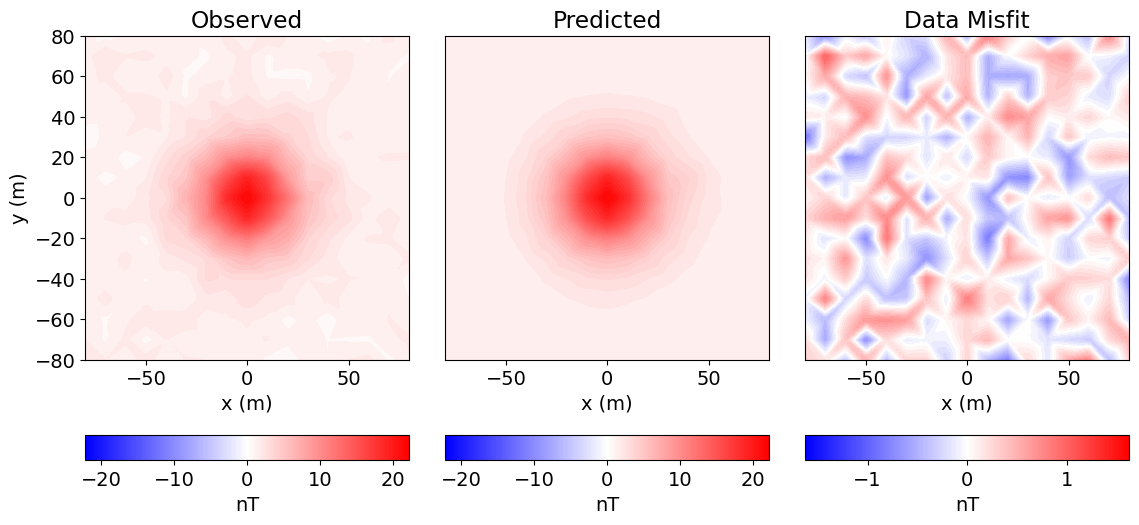

In [40]:
# Predicted data with final recovered model.
dpred_new = inv_prob_irls.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred_new, (dobs - dpred_new)]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["nT", "nT", "nT"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

## Plot True, L2 and IRLS Models

Here, we compare the models recovered from weighted least-squares and iteratively re-weighted least-squares inversion to the true model.

In [41]:
# Recreate True Model on a Tensor Mesh
background_susceptibility = 0.0001
sphere_susceptibility = 0.01

true_model = background_susceptibility * np.ones(n_tensor_active)
ind_sphere = model_builder.get_indices_sphere(
    np.r_[0.0, 0.0, 55.0], 16.0, tensor_mesh.cell_centers[active_tensor_cells]
)
true_model[ind_sphere] = sphere_susceptibility

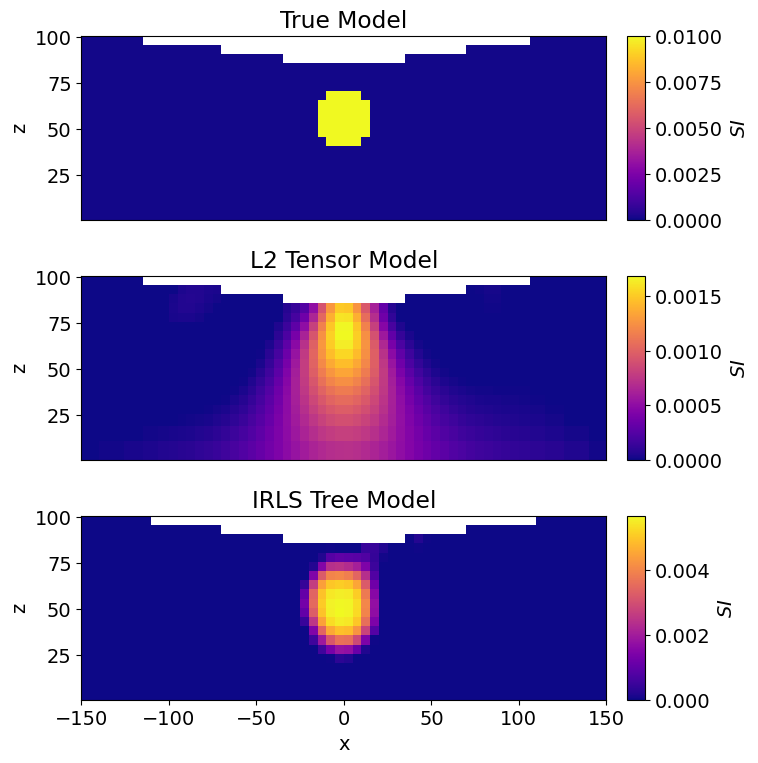

In [42]:
mesh_list = [tensor_mesh, tensor_mesh, tree_mesh]
ind_list = [active_tensor_cells, active_tensor_cells, ind_tree_active]
model_list = [true_model, recovered_tensor_model, recovered_tree_model]
title_list = ["True Model", "L2 Tensor Model", "IRLS Tree Model"]
cplot = 3 * [None]
cbar = 3 * [None]
norm = 3 * [None]

fig = plt.figure(figsize=(7, 8))
ax1 = [fig.add_axes([0.1, 0.7 - 0.3 * ii, 0.75, 0.23]) for ii in range(0, 3)]
ax2 = [fig.add_axes([0.88, 0.7 - 0.3 * ii, 0.025, 0.23]) for ii in range(0, 3)]

for ii, mesh in enumerate(mesh_list):
    plotting_map = maps.InjectActiveCells(mesh, ind_list[ii], np.nan)
    max_abs = np.max(np.abs(model_list[ii]))
    norm[ii] = mpl.colors.Normalize(vmin=0.0, vmax=max_abs)

    cplot[ii] = mesh.plot_slice(
        plotting_map * model_list[ii],
        normal="Y",
        ax=ax1[ii],
        ind=int(mesh.shape_cells[1] / 2),
        grid=False,
        pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm[ii]},
    )
    ax1[ii].set_xlim([-150, 150])
    ax1[ii].set_ylim([topo_xyz[:, -1].max() - 100, topo_xyz[:, -1].max()])
    if ii < 2:
        ax1[ii].set_xlabel("")
        ax1[ii].set_xticks([])
    ax1[ii].set_title(title_list[ii])

    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.plasma
    )
    cbar[ii].set_label("$SI$", labelpad=5)